更新：chunks 改单 chunk


## Dependency

In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "1" # 设置用GPU1
import gzip
import json
import logging
import shutil
from typing import Union
from argparse import Namespace

import numpy as np
import pandas as pd
import datatable as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

from mamba_ssm import Mamba2
from mamba_ssm.modules.mamba2_simple import Mamba2Simple as Mamba2Block # 原Mamba2Block
from torch_optimizer import Lamb

## Data

In [2]:
SUPPORTED_FILE_FORMATS = {"vcf", "csv", "tsv"}
class DataReader:
    def __init__(self):
        self.target_is_gonna_be_phased = None
        self.target_set = None
        self.target_sample_value_index = 2
        self.ref_sample_value_index = 2
        self.target_file_extension = None
        self.allele_count = 2
        self.genotype_vals = None
        self.ref_is_phased = None
        self.reference_panel = None
        self.VARIANT_COUNT = 0
        self.is_phased = False
        self.MISSING_VALUE = None
        self.ref_is_hap = False
        self.target_is_hap = False
        self.ref_n_header_lines = []
        self.ref_n_data_header = ""
        self.target_n_header_lines = []
        self.target_n_data_header = ""
        self.ref_separator = None
        self.map_values_1_vec = np.vectorize(self.__map_hap_2_ind_parent_1)
        self.map_values_2_vec = np.vectorize(self.__map_hap_2_ind_parent_2)
        self.map_haps_to_vec = np.vectorize(self.__map_haps_2_ind)
        self.delimiter_dictionary = {"vcf": "\t", "csv": ",", "tsv": "\t", "infer": "\t"}
        self.ref_file_extension = "vcf"
        self.test_file_extension = "vcf"
        self.target_is_phased = True

    def __read_csv(self, file_path, is_vcf=False, is_reference=False, separator="\t", first_column_is_index=True,
                   comments="##") -> pd.DataFrame:
        """Read CSV/VCF files"""
        print("Reading the file...")
        data_header = None
        path_sep = "/" if "/" in file_path else os.path.sep
        line_counter = 0
        root, ext = os.path.splitext(file_path)
        with gzip.open(file_path, 'rt') if ext == '.gz' else open(file_path, 'rt') as f_in:
            while True:
                line = f_in.readline()
                if line.startswith(comments):
                    line_counter += 1
                    if is_reference:
                        self.ref_n_header_lines.append(line)
                    else:
                        self.target_n_header_lines.append(line)
                else:
                    data_header = line
                    break
        if data_header is None:
            raise IOError("The file only contains comments!")
        df = dt.fread(file=file_path, sep=separator, header=True, skip_to_line=line_counter + 1)
        df = df.to_pandas()
        if first_column_is_index:
            df.set_index(df.columns[0], inplace=True)
        return df

    def __find_file_extension(self, file_path, file_format, delimiter):
        separator = "\t"
        found_file_format = None
        if file_format not in ["infer"] + list(SUPPORTED_FILE_FORMATS):
            raise ValueError("File extension must be one of {'vcf', 'csv', 'tsv', 'infer'}.")
        if file_format == 'infer':
            file_name_tokenized = file_path.split(".")
            for possible_extension in file_name_tokenized[::-1]:
                if possible_extension in SUPPORTED_FILE_FORMATS:
                    found_file_format = possible_extension
                    separator = self.delimiter_dictionary[possible_extension] if delimiter is None else delimiter
                    break
            if found_file_format is None:
                logging.warning("Could not infer the file type. Using tsv as the last resort.")
                found_file_format = "tsv"
        else:
            found_file_format = file_format
            separator = self.delimiter_dictionary[file_format] if delimiter is None else delimiter
        return found_file_format, separator

    def assign_training_set(self, file_path: str, target_is_gonna_be_phased_or_haps: bool,
                            variants_as_columns: bool = False, delimiter=None, file_format="infer",
                            first_column_is_index=True, comments="##") -> None:
        self.target_is_gonna_be_phased = target_is_gonna_be_phased_or_haps
        self.ref_file_extension, self.ref_separator = self.__find_file_extension(file_path, file_format, delimiter)

        self.reference_panel = self.__read_csv(file_path, is_reference=True, is_vcf=False, separator=self.ref_separator,
                                               first_column_is_index=first_column_is_index,
                                               comments=comments) if self.ref_file_extension != 'vcf' else self.__read_csv(
            file_path, is_reference=True, is_vcf=True, separator='\t', first_column_is_index=False, comments="##")

        if self.ref_file_extension != "vcf":
            if variants_as_columns:
                self.reference_panel = self.reference_panel.transpose()
            self.reference_panel.reset_index(drop=False, inplace=True)
            self.reference_panel.rename(columns={self.reference_panel.columns[0]: "ID"}, inplace=True)
        else:
            self.ref_sample_value_index += 8

        self.ref_is_hap = not ("|" in self.reference_panel.iloc[0, self.ref_sample_value_index - 1] or "/" in
                               self.reference_panel.iloc[0, self.ref_sample_value_index - 1])
        self.ref_is_phased = "|" in self.reference_panel.iloc[0, self.ref_sample_value_index - 1]

        if self.ref_is_hap and not target_is_gonna_be_phased_or_haps:
            raise ValueError(
                "Reference contains haploids while target will be unphased diploids. Model cannot predict target.")

        if not (self.ref_is_phased or self.ref_is_hap) and target_is_gonna_be_phased_or_haps:
            raise ValueError(
                "Reference contains unphased diploids while target will be phased/haploid. Model cannot predict target.")

        self.VARIANT_COUNT = self.reference_panel.shape[0]
        print(
            f"{self.reference_panel.shape[1] - (self.ref_sample_value_index - 1)} {'haploid' if self.ref_is_hap else 'diploid'} samples with {self.VARIANT_COUNT} variants found!")

        self.is_phased = target_is_gonna_be_phased_or_haps and (self.ref_is_phased or self.ref_is_hap)

        original_allele_sep = "|" if self.ref_is_phased or self.ref_is_hap else "/"
        final_allele_sep = "|" if self.is_phased else "/"

        def get_diploid_alleles(genotype_vals):
            allele_set = set()
            for genotype_val in genotype_vals:
                if genotype_val not in [".", ".|.", "./."]:
                    if final_allele_sep in genotype_val:
                        v1, v2 = genotype_val.split(final_allele_sep)
                        allele_set.update([v1, v2])
                    else:
                        allele_set.add(genotype_val)  # For haploids
            return np.array(list(allele_set))

        genotype_vals = pd.unique(self.reference_panel.iloc[:, self.ref_sample_value_index - 1:].values.ravel('K'))
        print(f"DEBUG: Unique genotypes in dataset: {genotype_vals[:10]}...")  # Show first 10

        if self.ref_is_phased and not target_is_gonna_be_phased_or_haps:
            phased_to_unphased_dict = {}
            for i in range(genotype_vals.shape[0]):
                key = genotype_vals[i]
                if "|" in key and key not in [".", ".|."]:
                    v1, v2 = [int(s) for s in genotype_vals[i].split(original_allele_sep)]
                    genotype_vals[i] = f"{min(v1, v2)}/{max(v1, v2)}"
                    phased_to_unphased_dict[key] = genotype_vals[i]
            if phased_to_unphased_dict:
                self.reference_panel.iloc[:, self.ref_sample_value_index - 1:].replace(phased_to_unphased_dict,
                                                                                       inplace=True)

        self.genotype_vals = np.unique(genotype_vals)
        self.alleles = get_diploid_alleles(self.genotype_vals) if not self.ref_is_hap else self.genotype_vals
        self.allele_count = len(self.alleles)
        self.MISSING_VALUE = self.allele_count if self.is_phased else len(self.genotype_vals)

        print(f"DEBUG: self.genotype_vals: {self.genotype_vals}")
        print(f"DEBUG: self.alleles: {self.alleles}")
        print(f"DEBUG: is_phased: {self.is_phased}")

        if self.is_phased:
            self.hap_map = {str(v): i for i, v in enumerate(list(sorted(self.alleles)))}
            self.hap_map.update({".": self.MISSING_VALUE})
            self.r_hap_map = {i: k for k, i in self.hap_map.items()}
            self.map_preds_2_allele = np.vectorize(lambda x: self.r_hap_map[x])
            print(f"DEBUG: hap_map: {self.hap_map}")
        else:
            unphased_missing_genotype = "./."
            self.replacement_dict = {g: i for i, g in enumerate(list(sorted(self.genotype_vals)))}
            self.replacement_dict[unphased_missing_genotype] = self.MISSING_VALUE
            self.reverse_replacement_dict = {v: k for k, v in self.replacement_dict.items()}
            print(f"DEBUG: replacement_dict: {self.replacement_dict}")

        self.SEQ_DEPTH = self.allele_count + 1 if self.is_phased else len(self.genotype_vals) + 1
        print(f"DEBUG: self.SEQ_DEPTH: {self.SEQ_DEPTH}")

    def assign_test_set(self, file_path, variants_as_columns=False, delimiter=None,
                        file_format="infer", first_column_is_index=True, comments="##") -> None:
        """Assign test set for imputation"""
        if self.reference_panel is None:
            raise RuntimeError("First you need to use 'DataReader.assign_training_set(...) to assign a training set.'")

        self.target_file_extension, separator = self.__find_file_extension(file_path, file_format, delimiter)

        test_df = self.__read_csv(file_path, is_reference=False, is_vcf=False, separator=separator,
                                  first_column_is_index=first_column_is_index,
                                  comments=comments) if self.target_file_extension != 'vcf' else self.__read_csv(
            file_path, is_reference=False, is_vcf=True, separator='\t', first_column_is_index=False, comments="##")

        if self.target_file_extension != "vcf":
            if variants_as_columns:
                test_df = test_df.transpose()
            test_df.reset_index(drop=False, inplace=True)
            test_df.rename(columns={test_df.columns[0]: "ID"}, inplace=True)
        else:
            self.target_sample_value_index += 8

        self.target_is_hap = not ("|" in test_df.iloc[0, self.target_sample_value_index - 1] or "/" in
                                  test_df.iloc[0, self.target_sample_value_index - 1])
        is_phased = "|" in test_df.iloc[0, self.target_sample_value_index - 1]
        test_var_count = test_df.shape[0]
        print(f"{test_var_count} {'haplotype' if self.target_is_hap else 'diplotype'} variants found!")

        # Validate compatibility
        if (self.target_is_hap or is_phased) and not (self.ref_is_phased or self.ref_is_hap):
            raise RuntimeError("The training set contains unphased data. The target must be unphased as well.")
        if self.ref_is_hap and not (self.target_is_hap or is_phased):
            raise RuntimeError("The training set contains haploids. Target set should be phased or haploids.")

        # Merge with reference panel to align variants
        self.target_set = test_df.merge(right=self.reference_panel[["ID"]], on='ID', how='right')
        if self.target_file_extension == "vcf" == self.ref_file_extension:
            self.target_set[self.reference_panel.columns[:9]] = self.reference_panel[self.reference_panel.columns[:9]]

        self.target_set = self.target_set.astype('str')
        missing_value = "." if self.target_is_hap else ".|." if self.is_phased else "./."
        self.target_set.fillna(missing_value, inplace=True)
        self.target_set.replace("nan", missing_value, inplace=True)
        print("Target set assignment done!")

    def __map_hap_2_ind_parent_1(self, x) -> int:
        return self.hap_map[x.split('|')[0]]

    def __map_hap_2_ind_parent_2(self, x) -> int:
        return self.hap_map[x.split('|')[1]]

    def __map_haps_2_ind(self, x) -> int:
        return self.hap_map[x]

    def get_ref_set(self, starting_var_index=0, ending_var_index=0) -> np.ndarray:
        if 0 <= starting_var_index < ending_var_index:
            data = self.reference_panel.iloc[starting_var_index:ending_var_index, self.ref_sample_value_index - 1:]
        else:
            data = self.reference_panel.iloc[:, self.ref_sample_value_index - 1:]

        if self.is_phased:
            is_haps = "|" not in data.iloc[0, 0]
            if not is_haps:
                # diploids to hap vecs
                _x = np.empty((data.shape[1] * 2, data.shape[0]), dtype=np.int32)
                _x[0::2] = self.map_values_1_vec(data.values.T)
                _x[1::2] = self.map_values_2_vec(data.values.T)
                return _x
            else:
                return self.map_haps_to_vec(data.values.T)
        else:
            return data.replace(self.replacement_dict).values.T.astype(np.int32)

    def get_target_set(self, starting_var_index=0, ending_var_index=0) -> np.ndarray:
        """Get target data for imputation"""
        if 0 <= starting_var_index < ending_var_index:
            data = self.target_set.iloc[starting_var_index:ending_var_index, self.target_sample_value_index - 1:]
        else:
            data = self.target_set.iloc[:, self.target_sample_value_index - 1:]

        if self.is_phased:
            is_haps = "|" not in data.iloc[0, 0]
            if not is_haps:
                # diploids to hap vecs
                _x = np.empty((data.shape[1] * 2, data.shape[0]), dtype=np.int32)
                _x[0::2] = self.map_values_1_vec(data.values.T)
                _x[1::2] = self.map_values_2_vec(data.values.T)
                return _x
            else:
                return self.map_haps_to_vec(data.values.T)
        else:
            return data.replace(self.replacement_dict).values.T.astype(np.int32)

    def __convert_unphased_probs_to_genotypes(self, allele_probs) -> np.ndarray:
        """Convert unphased probabilities to genotypes"""
        n_samples, n_variants, n_alleles = allele_probs.shape
        genotypes = np.zeros((n_samples, n_variants), dtype=object)

        for i in tqdm(range(n_samples)):
            for j in range(n_variants):
                unphased_probs = allele_probs[i, j]
                variant_genotypes = np.vectorize(self.reverse_replacement_dict.get)(
                    np.argmax(unphased_probs, axis=-1)).flatten()
                genotypes[i, j] = variant_genotypes
        return genotypes

    def __convert_hap_probs_to_diploid_genotypes(self, allele_probs) -> np.ndarray:
        """Convert haplotype probabilities to diploid genotypes"""
        n_haploids, n_variants, n_alleles = allele_probs.shape

        if n_haploids % 2 != 0:
            raise ValueError("Number of haploids should be even.")

        n_samples = n_haploids // 2
        genotypes = np.empty((n_samples, n_variants), dtype=object)
        haploids_as_diploids = allele_probs.reshape((n_samples, 2, n_variants, -1))
        variant_genotypes = self.map_preds_2_allele(np.argmax(haploids_as_diploids, axis=-1))

        def process_variant_in_sample(haps_for_sample_at_variant, variant_genotypes_for_sample_at_variant):
            if n_alleles > 2:
                return '|'.join(variant_genotypes_for_sample_at_variant)
            else:
                # Output GP (genotype probabilities)
                phased_probs = np.outer(haps_for_sample_at_variant[0], haps_for_sample_at_variant[1]).flatten()
                unphased_probs = np.array([phased_probs[0], phased_probs[1] + phased_probs[2], phased_probs[-1]])
                unphased_probs_str = ",".join([f"{v:.6f}" for v in unphased_probs])
                alt_dosage = np.dot(unphased_probs, [0, 1, 2])
                return '|'.join(variant_genotypes_for_sample_at_variant) + f":{unphased_probs_str}:{alt_dosage:.3f}"

        def process_sample(i):
            return np.array([
                process_variant_in_sample(haploids_as_diploids[i, :, j, :], variant_genotypes[i, :, j])
                for j in range(n_variants)
            ])

        # Parallel processing
        genotypes = Parallel(n_jobs=-1)(delayed(process_sample)(i) for i in tqdm(range(n_samples)))
        return np.array(genotypes)

    def __convert_hap_probs_to_hap_genotypes(self, allele_probs) -> np.ndarray:
        """Convert hap probabilities to hap genotypes"""
        return np.argmax(allele_probs, axis=1).astype(str)

    def __get_headers_for_output(self, contain_probs, chr=22):
        """Get VCF headers for output file"""
        headers = [
            "##fileformat=VCFv4.2",
            '''##source=BiMamba v1.0.0''',
            '''##INFO=<ID=AF,Number=A,Type=Float,Description="Estimated Alternate Allele Frequency">''',
            '''##INFO=<ID=MAF,Number=1,Type=Float,Description="Estimated Minor Allele Frequency">''',
            '''##INFO=<ID=AVG_CS,Number=1,Type=Float,Description="Average Call Score">''',
            '''##INFO=<ID=IMPUTED,Number=0,Type=Flag,Description="Marker was imputed">''',
            '''##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">''',
        ]
        probs_headers = [
            '''##FORMAT=<ID=DS,Number=A,Type=Float,Description="Estimated Alternate Allele Dosage : [P(0/1)+2*P(1/1)]">''',
            '''##FORMAT=<ID=GP,Number=G,Type=Float,Description="Estimated Posterior Probabilities for Genotypes 0/0, 0/1 and 1/1">'''
        ]
        if contain_probs:
            headers.extend(probs_headers)
        return headers

    def __convert_genotypes_to_vcf(self, genotypes, pred_format="GT:GP:DS"):
        """Convert genotypes to VCF format"""
        new_vcf = self.target_set.copy()
        new_vcf[new_vcf.columns[self.target_sample_value_index - 1:]] = genotypes
        new_vcf["FORMAT"] = pred_format
        new_vcf["QUAL"] = "."
        new_vcf["FILTER"] = "."
        new_vcf["INFO"] = "IMPUTED"
        return new_vcf

    def preds_to_genotypes(self, predictions: Union[str, np.ndarray]) -> pd.DataFrame:
        """Convert predictions to genotypes"""
        if isinstance(predictions, str):
            preds = np.load(predictions)
        else:
            preds = predictions

        target_df = self.target_set.copy()
        if not self.is_phased:
            target_df[
                target_df.columns[self.target_sample_value_index - 1:]] = self.__convert_unphased_probs_to_genotypes(
                preds).T
        elif self.target_is_hap:
            target_df[
                target_df.columns[self.target_sample_value_index - 1:]] = self.__convert_hap_probs_to_hap_genotypes(
                preds).T
        else:
            pred_format = "GT:GP:DS" if preds.shape[-1] == 2 else "GT"
            target_df = self.__convert_genotypes_to_vcf(self.__convert_hap_probs_to_diploid_genotypes(preds).T,
                                                        pred_format)
        return target_df

    def write_ligated_results_to_file(self, df: pd.DataFrame, file_name: str, compress=True) -> str:
        """Write results to file"""
        to_write_format = self.ref_file_extension
        file_path = f"{file_name}.{to_write_format}.gz" if compress else f"{file_name}.{to_write_format}"

        with gzip.open(file_path, 'wt') if compress else open(file_path, 'wt') as f_out:
            # Write headers
            if self.ref_file_extension == "vcf":
                f_out.write(
                    "\n".join(self.__get_headers_for_output(contain_probs="GP" in df["FORMAT"].values[0])) + "\n")
            else:
                f_out.write("\n".join(self.ref_n_header_lines))

        # Append data
        df.to_csv(file_path, sep=self.ref_separator, mode='a', index=False)
        return file_path

In [3]:
class GenomicDataset(Dataset):
    """Dataset class for genomic data with masking for training"""

    def __init__(self, data, targets, seq_depth, offset_before=0, offset_after=0,
                 training=True, masking_rates=(0.5, 0.99)):
        self.data = data
        self.targets = targets
        self.seq_depth = seq_depth
        self.offset_before = offset_before
        self.offset_after = offset_after
        self.training = training
        self.masking_rates = masking_rates

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx].copy()
        y = self.targets[idx]

        if self.training:
            # Apply masking
            seq_len = len(x)
            masking_rate = np.random.uniform(*self.masking_rates)
            mask_size = int(seq_len * masking_rate)
            mask_indices = np.random.choice(seq_len, mask_size, replace=False)
            x[mask_indices] = self.seq_depth - 1  # Missing value token

        # Convert to one-hot
        x_onehot = np.eye(self.seq_depth)[x]
        y_onehot = np.eye(self.seq_depth - 1)[y]

        return torch.FloatTensor(x_onehot), torch.FloatTensor(y_onehot)

class ImputationDataset(Dataset):
    """Dataset for imputation (no masking needed)"""

    def __init__(self, data, seq_depth):
        self.data = data
        self.seq_depth = seq_depth

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        # Convert to one-hot without masking
        x_onehot = np.eye(self.seq_depth)[x]
        return torch.FloatTensor(x_onehot)

## Model

EvoFill 单chunk module 版

In [4]:
class BiMambaBlock(nn.Module):
    """Bidirectional Mamba block for genomic sequence processing"""

    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_model = d_model

        # Forward and backward Mamba blocks
        self.mamba_forward = Mamba2(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

        self.mamba_backward = Mamba2(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model * 2, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.GELU()
        )

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        residual = x

        # Bidirectional processing
        x_norm = self.norm1(x)

        # Forward direction
        forward_out = self.mamba_forward(x_norm)

        # Backward direction (flip sequence)
        x_backward = torch.flip(x_norm, dims=[1])
        backward_out = self.mamba_backward(x_backward)
        backward_out = torch.flip(backward_out, dims=[1])

        # Concatenate bidirectional outputs
        bi_out = torch.cat([forward_out, backward_out], dim=-1)

        # FFN
        ffn_out = self.ffn(bi_out)
        ffn_out = self.dropout(ffn_out)

        # Residual connection
        out = self.norm2(residual + ffn_out)

        return out

class ConvBlock(nn.Module):
    """Convolutional block for local pattern extraction"""

    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.conv1 = nn.Conv1d(d_model, d_model, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(d_model, d_model, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(d_model, d_model, kernel_size=7, padding=3)

        self.conv_large1 = nn.Conv1d(d_model, d_model, kernel_size=7, padding=3)
        self.conv_large2 = nn.Conv1d(d_model, d_model, kernel_size=15, padding=7)

        self.conv_final = nn.Conv1d(d_model, d_model, kernel_size=3, padding=1)
        self.conv_reduce = nn.Conv1d(d_model, d_model, kernel_size=1)

        self.bn1 = nn.BatchNorm1d(d_model)
        self.bn2 = nn.BatchNorm1d(d_model)

        self.gelu = nn.GELU()

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        x = x.transpose(1, 2)  # (batch, d_model, seq_len)

        xa = self.gelu(self.conv1(x))

        xb = self.gelu(self.conv2(xa))
        xb = self.gelu(self.conv3(xb))

        xc = self.gelu(self.conv_large1(xa))
        xc = self.gelu(self.conv_large2(xc))

        xa = xb + xc
        xa = self.gelu(self.conv_final(xa))
        xa = self.bn1(xa)
        xa = self.gelu(self.conv_reduce(xa))
        xa = self.bn2(xa)
        xa = self.gelu(xa)

        return xa.transpose(1, 2)  # (batch, seq_len, d_model)

class CrossAttentionLayer(nn.Module):
    """Cross attention for integrating local and global features"""
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.cross_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            batch_first=True
        )

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model),
            nn.GELU()
        )

    def forward(self, local_repr, global_repr, start_offset=0, end_offset=0):
        local_norm = self.norm1(local_repr)
        global_norm = self.norm2(global_repr)

        # Apply offsets
        if start_offset > 0 or end_offset > 0:
            query = local_norm[:, start_offset:local_norm.shape[1] - end_offset]
        else:
            query = local_norm

        key = value = global_norm

        # Cross attention
        attn_output, _ = self.cross_attention(query, key, value)

        # Pad attn_output back to original length if offsets were applied
        if start_offset > 0 or end_offset > 0:
            pad_left = start_offset
            pad_right = end_offset
            attn_output = torch.nn.functional.pad(attn_output, (0, 0, pad_left, pad_right), mode='constant', value=0)

        # Skip connection
        attn_output = attn_output + local_norm  # Changed from +query to +local_norm

        # FFN
        attn_output = self.norm3(attn_output)
        ffn_output = self.ffn(attn_output)
        output = ffn_output + attn_output

        return output

class Mamba2CrossBlock(nn.Module):
    """
    用 Mamba2Simple 替代 MultiheadAttention 的交叉块。
    接口与原来 CrossAttentionLayer 保持一致，可直接替换。
    """
    def __init__(
        self,
        d_model,
        n_heads=8,            # 仅保留接口，无实际意义
        d_state=64,
        d_conv=4,
        expand=2,
        headdim=128,
        ngroups=1,
        chunk_size=256,
        dropout=0.0,
        device=None,
        dtype=None,
    ):
        super().__init__()
        self.d_model = d_model

        # 1. 归一化
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        # 2. Mamba2Simple 作为交叉建模核心
        self.ssd = Mamba2Block(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
            headdim=headdim,
            ngroups=ngroups,
            chunk_size=chunk_size,
            use_mem_eff_path=True,
            device=device,
            dtype=dtype,
        )

        # 3. FFN 保持不变
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model),
        )

    def forward(self, local_repr, global_repr, start_offset=0, end_offset=0):
        """
        local_repr: [B, L, D]
        global_repr: [B, G, D]
        输出:       [B, L, D]  （长度与 local_repr 保持一致）
        """
        B, L, D = local_repr.shape

        # 1. 归一化
        local_norm  = self.norm1(local_repr)
        global_norm = self.norm2(global_repr)

        # 2. 如果用了 offset，先截断 query 长度
        if start_offset > 0 or end_offset > 0:
            query = local_norm[:, start_offset:L - end_offset]
        else:
            query = local_norm

        # 3. 拼接：global 在前，local 在后，让 SSD 扫描时 local 能看到 global
        x = torch.cat([global_norm, query], dim=1)   # [B, G + L', D]
        x = self.ssd(x)                              # [B, G + L', D]
        x = x[:, global_norm.shape[1]:, :]           # 只取 local 对应部分 [B, L', D]

        # 4. pad 回原始长度（如果之前截断过）
        if start_offset > 0 or end_offset > 0:
            x = F.pad(x, (0, 0, start_offset, end_offset))  # [B, L, D]

        # 5. 残差连接
        x = x + local_norm

        # 6. FFN
        x = self.norm3(x)
        x = self.ffn(x) + x

        return x

class GenoEmbedding(nn.Module):
    """Genomic embedding layer with positional encoding"""

    def __init__(self, n_alleles, n_snps, d_model):
        super().__init__()
        self.d_model = d_model
        self.n_alleles = n_alleles
        self.n_snps = n_snps

        # Allele embedding
        self.allele_embedding = nn.Parameter(torch.randn(n_alleles, d_model))

        # Positional embedding
        self.position_embedding = nn.Embedding(n_snps, d_model)

        # Initialize parameters
        nn.init.xavier_uniform_(self.allele_embedding)

    def forward(self, x):
        # x shape: (batch, seq_len, n_alleles) - one-hot encoded
        batch_size, seq_len, _ = x.shape

        # Allele embedding
        embedded = torch.einsum('bsn,nd->bsd', x, self.allele_embedding)

        # Positional embedding
        positions = torch.arange(seq_len, device=x.device)
        pos_emb = self.position_embedding(positions).unsqueeze(0)

        return embedded + pos_emb

class ChunkModule(nn.Module):
    """Single chunk processing module with BiMamba"""

    def __init__(self, d_model, n_heads, start_offset=0, end_offset=0, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.start_offset = start_offset
        self.end_offset = end_offset

        # BiMamba block
        self.bimamba_block = BiMambaBlock(d_model)

        # Convolutional blocks
        self.conv_block1 = ConvBlock(d_model)
        self.conv_block2 = ConvBlock(d_model)
        self.conv_block3 = ConvBlock(d_model)

        # Cross attention
        # self.cross_attention = CrossAttentionLayer(d_model, n_heads)
        self.cross_attention = Mamba2CrossBlock(
            d_model=d_model,
            n_heads=n_heads,      # 仅保留接口，无实际用途
            d_state=64,
            d_conv=4,
            expand=2,
            headdim=128,
            ngroups=1,
            chunk_size=256,
        )

        # Additional layers
        self.dense = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.gelu = nn.GELU()

    def forward(self, x):
        # BiMamba processing
        xa0 = self.bimamba_block(x)

        # First conv block
        xa = self.conv_block1(xa0)
        xa_skip = self.conv_block2(xa)

        # Dense layer
        xa = self.gelu(self.dense(xa))
        xa = self.conv_block2(xa)

        # Cross attention
        xa = self.cross_attention(xa, xa0, self.start_offset, self.end_offset)
        xa = self.dropout(xa)

        # Final conv block
        xa = self.conv_block3(xa)

        # Concatenate with skip connection
        xa = torch.cat([xa_skip, xa], dim=-1)

        return xa

class EvoFill(nn.Module):
    """Main BiMamba model for genomic imputation"""

    def __init__(self,
                 d_model,
                 n_heads,
                 chunk_size=2048,
                 attention_range=64,
                 offset_before=0,
                 offset_after=0,
                 dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.chunk_size = chunk_size
        self.attention_range = attention_range
        self.offset_before = offset_before
        self.offset_after = offset_after
        self.dropout_rate = dropout_rate

        # Will be set during build
        self.seq_len = None
        self.n_alleles = None
        self.embedding = None
        self.chunk_modules = nn.ModuleList()
        self.final_conv = None
        self.output_conv = None

    def build(self, seq_len, n_alleles):
        """Build the model with specific sequence length and allele count"""
        self.seq_len = seq_len
        self.n_alleles = n_alleles

        # Embedding layer
        self.embedding = GenoEmbedding(n_alleles, seq_len, self.d_model)

        # Calculate chunks
        chunk_starts = list(range(0, seq_len, self.chunk_size))
        chunk_ends = [min(cs + self.chunk_size, seq_len) for cs in chunk_starts]
        mask_starts = [max(0, cs - self.attention_range) for cs in chunk_starts]
        mask_ends = [min(ce + self.attention_range, seq_len) for ce in chunk_ends]

        # Create chunk modules
        self.chunk_module = ChunkModule(
            d_model=self.d_model,
            n_heads=self.n_heads,
            start_offset=0,          # 不再给具体 offset
            end_offset=0,
            dropout_rate=self.dropout_rate
        )

        # Store chunk information
        self.chunk_starts = chunk_starts
        self.chunk_ends = chunk_ends
        self.mask_starts = mask_starts
        self.mask_ends = mask_ends

        # Final layers
        self.final_conv = nn.Conv1d(self.d_model * 2, self.d_model // 2,
                                    kernel_size=5, padding=2)
        self.output_conv = nn.Conv1d(self.d_model // 2, n_alleles - 1,
                                     kernel_size=5, padding=2)
        # self.output_proj = nn.Linear(self.d_model * 2, n_alleles - 1)

        self.gelu = nn.GELU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: (batch, seq_len, n_alleles)
        if self.embedding is None:
            raise RuntimeError("Model not built. Call build() first.")

        # Embedding
        x_embedded = self.embedding(x)

        # Process chunks
        chunk_outputs = []
        for i in range(len(self.chunk_starts)):
            pad_left  = self.chunk_starts[i] - self.mask_starts[i]
            pad_right = self.mask_ends[i] - self.chunk_ends[i]
            chunk_input = x_embedded[:, self.mask_starts[i]:self.mask_ends[i]]
            chunk_output = self.chunk_module(chunk_input)   # 共享权重
            if pad_left or pad_right:
                chunk_output = F.pad(chunk_output, (0, 0, pad_left, pad_right))
            chunk_outputs.append(chunk_output)
        # Concatenate chunks along sequence dimension
        x_concat = torch.cat(chunk_outputs, dim=1)

        # # Final processing
        x_concat = x_concat.transpose(1, 2)  # (batch, features, seq_len)
        x_final = self.gelu(self.final_conv(x_concat))
        x_output = self.output_conv(x_final)
        x_output = x_output.transpose(1, 2)  # (batch, seq_len, n_alleles-1)
        # x_output = self.output_proj(x_concat) 

        # Apply offsets
        if self.offset_before > 0 or self.offset_after > 0:
            x_output = x_output[:, self.offset_before:self.seq_len - self.offset_after]

        x_output = self.softmax(x_output)

        return x_output

In [5]:
n_alleles = 4  # 包含missing
model = EvoFill(
    d_model=256,
    n_heads=8,
    chunk_size=5120,
    attention_range=64, 
    offset_before=0,
    offset_after=0,
    dropout_rate=0.1,
).cuda()

B, L = 2, 5120
model.build(seq_len=L, n_alleles=n_alleles)
model = model.cuda()  

# 1. 生成输入
x = torch.randint(0, n_alleles, (B, L)).long().cuda()   # {0,1,2,3} 3=missing

# 2. -1 -> 3，并构造 one-hot（4 维）
x_map = x.clone()
x_onehot = torch.zeros(B, L, n_alleles, device='cuda')
x_onehot.scatter_(2, x_map.unsqueeze(-1), 1)

# 3. 前向
with torch.no_grad():
    probs = model(x_onehot)          # shape: (B,L,3)

# 4. 简单校验
assert torch.allclose(probs.sum(dim=-1), torch.ones(B, L, device='cuda'), atol=1e-5), \
    "概率未归一"
print("✅ 含缺失数据前向通过，输出形状:", probs.shape)

✅ 含缺失数据前向通过，输出形状: torch.Size([2, 5120, 3])


## Loss

In [5]:
class ImputationLoss(nn.Module):
    """Custom loss function for genomic imputation"""

    def __init__(self, use_r2=True, 
                 use_focal=False, #  all dummy 
                 group_size=None,
                 gamma=None,
                 alpha=None,
                 eps=None,
                 use_gradnorm=None,
                 gn_alpha=None,
                 gn_lr_w=None,):
        super().__init__()
        self.use_r2_loss = use_r2
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
        self.kl_loss = nn.KLDivLoss(reduction='sum')

    def calculate_minimac_r2(self, pred_alt_allele_probs, gt_alt_af):
        """Calculate Minimac-style RÂ² metric"""
        mask = torch.logical_or(torch.eq(gt_alt_af, 0.0), torch.eq(gt_alt_af, 1.0))
        gt_alt_af = torch.where(mask, 0.5, gt_alt_af)
        denom = gt_alt_af * (1.0 - gt_alt_af)
        denom = torch.where(denom < 0.01, 0.01, denom)
        r2 = torch.mean(torch.square(pred_alt_allele_probs - gt_alt_af), dim=0) / denom
        r2 = torch.where(mask, torch.zeros_like(r2), r2)
        return r2

    def forward(self, y_pred, y_true):
        y_true = y_true.float()

        # Convert to proper format for losses
        y_true_ce = torch.argmax(y_true, dim=-1)  # For CrossEntropy
        y_pred_log = torch.log(y_pred + 1e-8)  # For KL divergence

        # Basic losses
        ce_loss = self.ce_loss(y_pred.view(-1, y_pred.size(-1)), y_true_ce.view(-1))
        kl_loss = self.kl_loss(y_pred_log.view(-1, y_pred.size(-1)),
                               y_true.view(-1, y_true.size(-1)))

        total_loss = ce_loss + kl_loss

        if self.use_r2_loss:
            batch_size = y_true.size(0)
            group_size = 4
            num_full_groups = batch_size // group_size

            if num_full_groups > 0:
                y_true_grouped = y_true[:num_full_groups * group_size].view(
                    num_full_groups, group_size, *y_true.shape[1:])
                y_pred_grouped = y_pred[:num_full_groups * group_size].view(
                    num_full_groups, group_size, *y_pred.shape[1:])

                r2_loss = 0.0
                for i in range(num_full_groups):
                    gt_alt_af = torch.count_nonzero(
                        torch.argmax(y_true_grouped[i], dim=-1), dim=0
                    ).float() / group_size

                    pred_alt_allele_probs = torch.sum(y_pred_grouped[i][:, :, 1:], dim=-1)
                    r2_loss += -torch.sum(self.calculate_minimac_r2(
                        pred_alt_allele_probs, gt_alt_af)) * group_size

                total_loss += r2_loss

        return total_loss, None

In [5]:
B, L = 12, 1000
logits = torch.randn(B, L, 3).cuda()
targets = torch.randint(0, 3, (B, L)).cuda()
y_true_oh = F.one_hot(targets.long(), num_classes=3).float().cuda()
# targets[0, :10] = -1   # 模拟缺失

loss_fn = ImputationLoss(use_r2=True)
loss,_ = loss_fn(logits, y_true_oh)
print(logits.shape, y_true_oh.shape)
print(loss.item())          # 应在 0.x ~ 2.x 之间

torch.Size([12, 1000, 3]) torch.Size([12, 1000, 3])
nan


## Train

In [6]:
def remove_similar_rows(array):
    """Remove duplicate haploids from training set"""
    print("Finding duplicate haploids in training set.")
    unique_array = np.unique(array, axis=0)
    print(f"Removed {len(array) - len(unique_array)} rows. {len(unique_array)} training samples remaining.")
    return unique_array

def create_directories(save_dir, models_dir="models", outputs="out") -> None:
    """Create necessary directories"""
    for dd in [save_dir, f"{save_dir}/{models_dir}", f"{save_dir}/{outputs}"]:
        if not os.path.exists(dd):
            os.makedirs(dd)

def clear_dir(path) -> None:
    """Clear directory if it exists"""
    if os.path.exists(path):
        shutil.rmtree(path)

def load_chunk_info(save_dir, break_points):
    """Load chunk training status information"""
    chunk_info = {ww: False for ww in list(range(len(break_points) - 1))}
    if os.path.isfile(f"{save_dir}/models/chunks_info.json"):
        with open(f"{save_dir}/models/chunks_info.json", 'r') as f:
            loaded_chunks_info = json.load(f)
            if isinstance(loaded_chunks_info, dict) and len(loaded_chunks_info) == len(chunk_info):
                print("Resuming the training...")
                chunk_info = {int(k): v for k, v in loaded_chunks_info.items()}
    return chunk_info

def save_chunk_status(save_dir, chunk_info) -> None:
    """Save chunk training status information"""
    with open(f"{save_dir}/models/chunks_info.json", "w") as outfile:
        json.dump(chunk_info, outfile)

def create_model(args, seq_len, n_alleles):
    """Create BiMamba model"""
    model = EvoFill(
        d_model=args.embed_dim,
        n_heads=args.na_heads,
        chunk_size=args.cs,
        attention_range=args.co,
        offset_before=getattr(args, 'offset_before', 0),
        offset_after=getattr(args, 'offset_after', 0),
        dropout_rate=0.1
    )

    # Build the model
    model.build(seq_len, n_alleles)
    return model

In [7]:
MAF_BINS = [(0.00, 0.05), (0.05, 0.10), (0.10, 0.20),
            (0.20, 0.30), (0.30, 0.40), (0.40, 0.50)]

def precompute_maf(gts_np, mask_int=-1):
    """
    gts_np: (N, L)  int64
    return:
        maf: (L,) float32
        bin_cnt: list[int] 长度 6，对应 6 个 bin 的位点数量
    """
    L = gts_np.shape[1]
    maf = np.zeros(L, dtype=np.float32)
    bin_cnt = [0] * 6

    for l in range(L):
        alleles = gts_np[:, l]
        alleles = alleles[alleles != mask_int]   # 去掉缺失
        if alleles.size == 0:
            maf[l] = 0.0
            continue

        uniq, cnt = np.unique(alleles, return_counts=True)
        total = cnt.sum()
        freq = cnt / total
        freq[::-1].sort()
        maf_val = freq[1] if len(freq) > 1 else 0.0
        maf[l] = maf_val

        # 统计 bin
        for i, (lo, hi) in enumerate(MAF_BINS):
            if lo <= maf_val < hi:
                bin_cnt[i] += 1
                break

    return maf, bin_cnt

def imputation_maf_accuracy_epoch(all_logits, all_gts, global_maf, mask=None):
    """
    all_logits: (N, L, C)
    all_gts:    (N, L, C) one-hot
    global_maf: (L,)
    mask:       (N, L) 或 None
    return:     list[float] 长度 6
    """
    # 1. 预测 vs 真实
    all_gts = all_gts.argmax(dim=-1)      # (N, L)
    preds   = all_logits.argmax(dim=-1)   # (N, L)

    # 2. 如果没有外部 mask，就默认全 1
    if mask is None:
        mask = torch.ones_like(all_gts, dtype=torch.bool)   # (N, L)
    correct = (preds == all_gts) & mask                   # (N, L)

    # 3. MAF 条件 -> (1, L) 再广播到 (N, L)
    maf = global_maf.unsqueeze(0)                         # (1, L)

    # 4. 分 bin 计算
    accs = []
    for lo, hi in MAF_BINS:
        maf_bin = mask & (maf >= lo) & (maf < hi)                # (1, L)
        n_cor = (correct & maf_bin).sum()
        n_tot = maf_bin.sum()
        accs.append(100*(n_cor / n_tot).item() if n_tot > 0 else 0.0)
    return accs

In [ ]:
# ---------------- 以下即命令行参数对应的行内变量 ----------------
mode                 = 'train'
restart_training     = True          # 对应命令行 1
ref                  = '/home/qmtang/mnt_qmtang/EvoFill/data/sim_s2_250901/YRI_CEU_chr22.vcf.gz'
tihp                 = True          # 对应命令行 1
which_chunk          = 1            # All chunkss
save_dir             = '/home/qmtang/EvoFill/data/mam_YRI_1chunkmod'
co                   = 64
cs                   = 1024
sites_per_model      = 8192
max_mr               = 0.7
min_mr               = 0.3
epochs               = 100
na_heads             = 8
embed_dim            = 64
lr                   = 0.001
weight_decay         = 1e-5
batch_size_per_gpu   = 32
use_r2               = True
use_focal            = True
earlystop_patience   = 9
verbose              = 1
# -------------------------------------------------------------

# 组装成 Namespace
args = Namespace(
    restart_training=restart_training,
    ref=ref,
    tihp=tihp,
    which_chunk=which_chunk,
    save_dir=save_dir,
    co=co,
    cs=cs,
    sites_per_model=sites_per_model,
    max_mr=max_mr,
    min_mr=min_mr,
    epochs=epochs,
    na_heads=na_heads,
    embed_dim=embed_dim,
    lr=lr,
    weight_decay=weight_decay,
    batch_size_per_gpu=batch_size_per_gpu,
    use_r2=use_r2,
    earlystop_patience=earlystop_patience,
    verbose=verbose,
)

assert args.max_mr > 0
assert args.min_mr > 0
assert args.max_mr >= args.min_mr

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
create_directories(args.save_dir)
with open(f"{args.save_dir}/commandline_args.json", 'w') as f:
    json.dump(vars(args), f, indent=4)

# Load data
dr = DataReader()
dr.assign_training_set(
    file_path=args.ref,
    target_is_gonna_be_phased_or_haps=args.tihp,
    variants_as_columns=getattr(args, 'ref_vac', False),
    delimiter=getattr(args, 'ref_sep', None),
    file_format=getattr(args, 'ref_file_format', 'infer'),
    first_column_is_index=getattr(args, 'ref_fcai', True),
    comments=getattr(args, 'ref_comment', '##')
)

# Split data for validation
n_samples = dr.get_ref_set(0, 1).shape[0]
val_n_samples = args.batch_size_per_gpu * getattr(args, 'val_n_batches', 8)
x_train_indices, x_valid_indices = train_test_split(
    range(n_samples),
    test_size=val_n_samples,
    random_state=getattr(args, 'random_seed', 2022),
    shuffle=True
)

# Process chunks
break_points = list(np.arange(0, dr.VARIANT_COUNT, args.sites_per_model)) + [dr.VARIANT_COUNT]
chunks_done = load_chunk_info(args.save_dir, break_points)

for w in range(len(break_points) - 1):
    if chunks_done[w]:
        print(f"Skipping chunk {w + 1}/{len(break_points) - 1} due to previous training.")
        continue
    if args.which_chunk != -1 and w + 1 != args.which_chunk:
        print(f"Skipping chunk {w + 1}/{len(break_points) - 1} due to your request using --which-chunk.")
        continue

    print(f"Training on chunk {w + 1}/{len(break_points) - 1}")

    # Calculate chunk boundaries
    final_start_pos = max(0, break_points[w] - 2 * args.co)
    final_end_pos = min(dr.VARIANT_COUNT, break_points[w + 1] + 2 * args.co)
    offset_before = break_points[w] - final_start_pos
    offset_after = final_end_pos - break_points[w + 1]

    # Get data for this chunk
    ref_set = dr.get_ref_set(final_start_pos, final_end_pos).astype(np.int32)
    print(f"Data shape: {ref_set.shape}")

    # Remove duplicates from training
    ref_set_train = remove_similar_rows(ref_set[x_train_indices])
    ref_set_val = ref_set[x_valid_indices]

    # MAF bins counts
    valid_slice = slice(offset_before,
                        ref_set_train.shape[1] - offset_after)
    chunk_maf, chunk_bin_cnt = precompute_maf(
        ref_set_train[:, valid_slice], 
        mask_int=-1
    )
    chunk_maf = torch.from_numpy(chunk_maf).to(device)          # (L_chunk,)
    if args.verbose:
        print('Chunk MAF-bin counts:', chunk_bin_cnt)

    # Create targets (same as input for reconstruction)
    target_train = ref_set_train[:, offset_before:ref_set_train.shape[1] - offset_after]
    target_val = ref_set_val[:, offset_before:ref_set_val.shape[1] - offset_after]

    # Create datasets
    train_dataset = GenomicDataset(
        ref_set_train, target_train, dr.SEQ_DEPTH,
        offset_before, offset_after, training=True,
        masking_rates=(args.min_mr, args.max_mr)
    )

    val_dataset = GenomicDataset(
        ref_set_val, target_val, dr.SEQ_DEPTH,
        offset_before, offset_after, training=False,
        masking_rates=(args.min_mr, args.max_mr)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size_per_gpu,
                                shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size_per_gpu,
                            shuffle=False, num_workers=4, pin_memory=True)

    # Create model
    seq_len = ref_set.shape[1]
    model = create_model(args, seq_len, dr.SEQ_DEPTH)
    model.offset_before = offset_before
    model.offset_after = offset_after
    model.to(device)

    # Loss and optimizer
    criterion = ImputationLoss(use_r2=getattr(args, 'use_r2', True),use_focal=getattr(args, 'use_focal', True))
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    # optimizer = Lamb(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )

    # Training loop
    best_loss = float('inf')
    patience = args.earlystop_patience
    patience_counter = 0

    for epoch in range(args.epochs):
        model.train()
        train_loss = 0.0
        train_logits, train_gts, train_mask = [], [], []

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{args.epochs}', leave=False)
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss, logs = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})

            # === 收集训练结果 ===
            mask = data[..., -1].bool()         # 只关心被 mask 的位点
            train_logits.append(output.detach())
            train_gts.append(target.detach())
            train_mask.append(mask)

        # 训练集 MAF-acc
        train_logits = torch.cat(train_logits, dim=0)
        train_gts    = torch.cat(train_gts,    dim=0)
        train_mask   = torch.cat(train_mask,   dim=0)
        # 只保留有效位点（去掉 offset  padding）
        if model.offset_before > 0 or model.offset_after > 0:
            train_mask   = train_mask  [:, model.offset_before : train_mask.shape[1]  -model.offset_after]
        train_maf_accs = imputation_maf_accuracy_epoch(train_logits, train_gts, chunk_maf, mask=train_mask)

        # ----------- 验证循环同理 ------------
        model.eval()
        val_loss = 0.0
        val_logits, val_gts = [], []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss, logs = criterion(output, target)
                val_loss += loss.item()

                mask = data[..., -1].bool()
                val_logits.append(output)
                val_gts.append(target)

        val_logits = torch.cat(val_logits, dim=0)
        val_gts    = torch.cat(val_gts,    dim=0)
        val_maf_accs = imputation_maf_accuracy_epoch(
            val_logits, val_gts, chunk_maf,  mask=None,)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss   = val_loss   / len(val_loader)

        if args.verbose >= 1:
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss   = val_loss   / len(val_loader)
            print(f'Chunk {w + 1}, Epoch {epoch + 1}/{args.epochs}, '
                  f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            # 用 DataFrame 打印 MAF-bin 结果
            maf_df = pd.DataFrame({
                'MAF_bin': ['(0.00, 0.05)', '(0.05, 0.10)', '(0.10, 0.20)',
                            '(0.20, 0.30)', '(0.30, 0.40)', '(0.40, 0.50)'],
                'Counts':  [f"{c}" for c in chunk_bin_cnt],
                'Train':   [f"{acc:.2f}" for acc in train_maf_accs],
                'Val':     [f"{acc:.2f}" for acc in val_maf_accs]
            })
            print(maf_df.to_string(index=False))

        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            import os
            os.makedirs(f'{args.save_dir}/models', exist_ok=True)
            torch.save(model.state_dict(), f'{args.save_dir}/models/w_{w}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if args.verbose >= 1:
                    print('Early stopping triggered')
                break

    # Mark chunk as done
    chunks_done[w] = True
    save_chunk_status(args.save_dir, chunks_done)

    # Clean up
    del ref_set, train_dataset, val_dataset, train_loader, val_loader, model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

Using device: cuda
Reading the file...
2000 diploid samples with 56145 variants found!
DEBUG: Unique genotypes in dataset: ['0|0' '0|1' '1|0' '1|1' '2|0' '2|1' '2|2' '1|2' '0|2']...
DEBUG: self.genotype_vals: ['0|0' '0|1' '0|2' '1|0' '1|1' '1|2' '2|0' '2|1' '2|2']
DEBUG: self.alleles: ['0' '1' '2']
DEBUG: is_phased: True
DEBUG: hap_map: {'0': 0, '1': 1, '2': 2, '.': 3}
DEBUG: self.SEQ_DEPTH: 4
Training on chunk 1/7
Data shape: (4000, 8320)
Finding duplicate haploids in training set.
Removed 1175 rows. 2569 training samples remaining.
Chunk MAF-bin counts: [7421, 224, 210, 129, 108, 100]


Chunk 1, Epoch 1/100, Train Loss: 214359.2439, Val Loss: 202167.6660
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 97.84 99.43
(0.05, 0.10)    224 86.88 89.00
(0.10, 0.20)    210 75.31 78.12
(0.20, 0.30)    129 64.34 64.07
(0.30, 0.40)    108 54.16 54.23
(0.40, 0.50)    100 49.85 52.21


Chunk 1, Epoch 2/100, Train Loss: 187027.4154, Val Loss: 195928.0684
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.45
(0.05, 0.10)    224 90.78 87.11
(0.10, 0.20)    210 84.00 75.68
(0.20, 0.30)    129 73.67 63.70
(0.30, 0.40)    108 63.25 55.13
(0.40, 0.50)    100 54.27 54.53


Chunk 1, Epoch 3/100, Train Loss: 175758.8913, Val Loss: 178223.4082
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.41
(0.05, 0.10)    224 90.92 88.34
(0.10, 0.20)    210 84.53 82.62
(0.20, 0.30)    129 74.64 67.94
(0.30, 0.40)    108 64.20 57.77
(0.40, 0.50)    100 56.00 55.92


Chunk 1, Epoch 4/100, Train Loss: 166098.8228, Val Loss: 171743.4355
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.48
(0.05, 0.10)    224 90.93 87.89
(0.10, 0.20)    210 84.91 79.42
(0.20, 0.30)    129 75.27 68.03
(0.30, 0.40)    108 64.48 57.17
(0.40, 0.50)    100 56.36 55.94


Chunk 1, Epoch 5/100, Train Loss: 162404.2021, Val Loss: 170940.4609
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.45
(0.05, 0.10)    224 90.99 87.11
(0.10, 0.20)    210 84.95 78.66
(0.20, 0.30)    129 75.26 67.89
(0.30, 0.40)    108 64.73 57.41
(0.40, 0.50)    100 56.89 54.99


Chunk 1, Epoch 6/100, Train Loss: 161229.0400, Val Loss: 168589.9512
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.46
(0.05, 0.10)    224 91.02 87.68
(0.10, 0.20)    210 84.99 79.80
(0.20, 0.30)    129 75.59 70.04
(0.30, 0.40)    108 65.44 57.58
(0.40, 0.50)    100 57.32 56.39


Chunk 1, Epoch 7/100, Train Loss: 160732.9456, Val Loss: 169900.2422
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.41
(0.05, 0.10)    224 91.01 87.54
(0.10, 0.20)    210 85.03 77.11
(0.20, 0.30)    129 75.82 68.29
(0.30, 0.40)    108 65.70 56.72
(0.40, 0.50)    100 57.33 55.90


Chunk 1, Epoch 8/100, Train Loss: 160374.4146, Val Loss: 168177.6133
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.39
(0.05, 0.10)    224 91.03 87.48
(0.10, 0.20)    210 85.20 80.76
(0.20, 0.30)    129 76.08 70.31
(0.30, 0.40)    108 65.83 60.44
(0.40, 0.50)    100 57.94 57.04


Chunk 1, Epoch 9/100, Train Loss: 160055.5030, Val Loss: 168834.1582
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.42
(0.05, 0.10)    224 91.03 87.52
(0.10, 0.20)    210 85.08 79.95
(0.20, 0.30)    129 76.14 69.32
(0.30, 0.40)    108 66.25 60.69
(0.40, 0.50)    100 59.13 57.73


Chunk 1, Epoch 10/100, Train Loss: 159606.2027, Val Loss: 167337.4238
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.35
(0.05, 0.10)    224 91.04 87.74
(0.10, 0.20)    210 85.13 82.41
(0.20, 0.30)    129 76.04 72.57
(0.30, 0.40)    108 66.62 63.06
(0.40, 0.50)    100 60.51 59.75


Chunk 1, Epoch 11/100, Train Loss: 159214.7253, Val Loss: 166372.0059
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.37
(0.05, 0.10)    224 91.02 88.98
(0.10, 0.20)    210 85.00 81.64
(0.20, 0.30)    129 75.92 72.59
(0.30, 0.40)    108 66.68 64.15
(0.40, 0.50)    100 61.16 59.55


Chunk 1, Epoch 12/100, Train Loss: 158891.7496, Val Loss: 168508.1387
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.27
(0.05, 0.10)    224 91.01 87.84
(0.10, 0.20)    210 84.94 78.78
(0.20, 0.30)    129 76.03 69.37
(0.30, 0.40)    108 67.14 63.01
(0.40, 0.50)    100 62.54 58.53


Chunk 1, Epoch 13/100, Train Loss: 158466.6064, Val Loss: 167441.3125
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.35
(0.05, 0.10)    224 91.08 87.56
(0.10, 0.20)    210 85.08 80.06
(0.20, 0.30)    129 76.21 69.57
(0.30, 0.40)    108 67.68 62.49
(0.40, 0.50)    100 63.29 58.75


Chunk 1, Epoch 14/100, Train Loss: 158220.4221, Val Loss: 166295.6191
     MAF_bin Counts Train   Val
(0.00, 0.05)   7421 99.58 99.31
(0.05, 0.10)    224 91.11 88.53
(0.10, 0.20)    210 85.20 81.68
(0.20, 0.30)    129 76.32 72.82
(0.30, 0.40)    108 68.09 64.34
(0.40, 0.50)    100 63.59 60.98


KeyboardInterrupt: 

In [ ]:
# ---------------- 以下即命令行参数对应的行内变量 ----------------
mode                 = 'train'
restart_training     = True          # 对应命令行 1
ref                  = '/home/qmtang/mnt_qmtang/EvoFill/data/sim_s2_250901/YRI_CEU_chr22.vcf.gz'
tihp                 = True          # 对应命令行 1
which_chunk          = -1            # All chunkss
save_dir             = '/home/qmtang/EvoFill/data/mam_YRI_1model'
co                   = 64
cs                   = 1024
sites_per_model      = 8192
max_mr               = 0.7
min_mr               = 0.3
epochs               = 100
na_heads             = 8
embed_dim            = 64
lr                   = 0.001
weight_decay         = 1e-5
batch_size_per_gpu   = 32
use_r2               = True
use_focal            = True
earlystop_patience   = 9
verbose              = 1
# -------------------------------------------------------------

# 组装成 Namespace
args = Namespace(
    restart_training=restart_training,
    ref=ref,
    tihp=tihp,
    which_chunk=which_chunk,
    save_dir=save_dir,
    co=co,
    cs=cs,
    sites_per_model=sites_per_model,
    max_mr=max_mr,
    min_mr=min_mr,
    epochs=epochs,
    na_heads=na_heads,
    embed_dim=embed_dim,
    lr=lr,
    weight_decay=weight_decay,
    batch_size_per_gpu=batch_size_per_gpu,
    use_r2=use_r2,
    earlystop_patience=earlystop_patience,
    verbose=verbose,
)

assert args.max_mr > 0
assert args.min_mr > 0
assert args.max_mr >= args.min_mr

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
create_directories(args.save_dir)
with open(f"{args.save_dir}/commandline_args.json", 'w') as f:
    json.dump(vars(args), f, indent=4)

# Load data
dr = DataReader()
dr.assign_training_set(
    file_path=args.ref,
    target_is_gonna_be_phased_or_haps=args.tihp,
    variants_as_columns=getattr(args, 'ref_vac', False),
    delimiter=getattr(args, 'ref_sep', None),
    file_format=getattr(args, 'ref_file_format', 'infer'),
    first_column_is_index=getattr(args, 'ref_fcai', True),
    comments=getattr(args, 'ref_comment', '##')
)

# Split data for validation
n_samples = dr.get_ref_set(0, 1).shape[0]
val_n_samples = args.batch_size_per_gpu * getattr(args, 'val_n_batches', 8)
x_train_indices, x_valid_indices = train_test_split(
    range(n_samples),
    test_size=val_n_samples,
    random_state=getattr(args, 'random_seed', 2022),
    shuffle=True
)
break_points = list(np.arange(0, dr.VARIANT_COUNT, args.sites_per_model)) + [dr.VARIANT_COUNT]
n_chunk = len(break_points) - 1
chunks_done = load_chunk_info(args.save_dir, break_points)

# ------------------------------------------------------------------
# 1. 只建一次模型、loss、optimizer、scheduler（跨 chunk 共享）
# ------------------------------------------------------------------
seq_len_full = dr.VARIANT_COUNT          # 最大可能长度，用于建模型
model = create_model(args, seq_len_full, dr.SEQ_DEPTH).to(device)

criterion = ImputationLoss(use_r2=getattr(args, 'use_r2', True),use_focal=getattr(args, 'use_focal', True))
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7)

# 全局持久化路径
GLOBAL_STATE_PATH = f'{args.save_dir}/global_state.pt'
MODEL_PATH        = f'{args.save_dir}/best_model.pt'

# -------------- 断点续跑：优先加载全局状态 --------------
best_loss_so_far = float('inf')
start_chunk = 0
if os.path.isfile(GLOBAL_STATE_PATH):
    state_dict = torch.load(GLOBAL_STATE_PATH, map_location=device)
    model.load_state_dict(state_dict['model'])
    optimizer.load_state_dict(state_dict['optimizer'])
    scheduler.load_state_dict(state_dict['scheduler'])
    best_loss_so_far = state_dict['best_loss']
    start_chunk       = state_dict['finished_chunk'] + 1   # 下一个待跑
    print(f'[Resume] 已加载全局状态，best_loss={best_loss_so_far:.4f}，'
          f'继续跑 chunk {start_chunk + 1}/{n_chunk}')
else:
    print('[Fresh] 从头训练，所有 chunk 共享同一模型')

# ------------------------------------------------------------------
# 2. 按 chunk 顺序训练（每个 chunk 只跑数据，不动模型结构）
# ------------------------------------------------------------------
for w in range(start_chunk, n_chunk):
    if args.which_chunk != -1 and (w + 1) != args.which_chunk:
        print(f'Skip chunk {w + 1}/{n_chunk} by --which-chunk.')
        continue
    if chunks_done[w]:
        print(f'Skip chunk {w + 1}/{n_chunk} (already done).')
        continue

    print(f'\n===== Training on chunk {w + 1}/{n_chunk} =====')
    # --------------- 2.1 取数据（含左右 overlap） ---------------
    final_start = max(0, break_points[w] - 2 * args.co)
    final_end   = min(dr.VARIANT_COUNT, break_points[w + 1] + 2 * args.co)
    offset_b    = break_points[w] - final_start
    offset_a    = final_end - break_points[w + 1]

    ref_set = dr.get_ref_set(final_start, final_end).astype(np.int32)
    ref_set_train = remove_similar_rows(ref_set[x_train_indices])
    ref_set_val   = ref_set[x_valid_indices]

    # --------------- 2.2 MAF / target / dataset ---------------
    valid_slice = slice(offset_b, ref_set_train.shape[1] - offset_a)
    chunk_maf, chunk_bin_cnt = precompute_maf(
        ref_set_train[:, valid_slice], mask_int=-1)
    chunk_maf = torch.from_numpy(chunk_maf).to(device)

    target_train = ref_set_train[:, offset_b:-offset_a if offset_a else None]
    target_val   = ref_set_val  [:, offset_b:-offset_a if offset_a else None]

    train_ds = GenomicDataset(ref_set_train, target_train, dr.SEQ_DEPTH,
                              offset_b, offset_a, training=True,
                              masking_rates=(args.min_mr, args.max_mr))
    val_ds   = GenomicDataset(ref_set_val,   target_val,   dr.SEQ_DEPTH,
                              offset_b, offset_a, training=False,
                              masking_rates=(args.min_mr, args.max_mr))

    train_loader = DataLoader(train_ds, batch_size=args.batch_size_per_gpu,
                              shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=args.batch_size_per_gpu,
                              shuffle=False, num_workers=4, pin_memory=True)

    # --------------- 2.3 本 chunk 内 epoch 训练 ---------------
    patience_counter = 0
    for epoch in range(args.epochs):
        # ---------------- train ----------------
        model.train()
        train_loss, logits_list, gts_list, mask_list = 0., [], [], []
        for data, target in tqdm(train_loader, desc=f'Chunk-{w+1} Epoch-{epoch+1}'):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            data = data.permute(0, 2, 1).contiguous()      # 进模型前
            output = model(data)
            output = output.permute(0, 2, 1).contiguous()  # 出模型后
            loss, _ = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            mask = data[..., -1].bool()
            logits_list.append(output.detach())
            gts_list.append(target.detach())
            mask_list.append(mask)

        # ---- 训练集 MAF-acc ----
        train_logits = torch.cat(logits_list, dim=0)
        train_gts    = torch.cat(gts_list,    dim=0)
        train_mask   = torch.cat(mask_list,   dim=0)
        if offset_b or offset_a:
            train_mask = train_mask[:, offset_b:-offset_a if offset_a else None]
        train_maf_accs = imputation_maf_accuracy_epoch(
            train_logits, train_gts, chunk_maf, mask=train_mask)

        # ---------------- val ----------------
        model.eval()
        val_loss, val_logits, val_gts = 0., [], []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss, _ = criterion(output, target)
                val_loss += loss.item()
                val_logits.append(output)
                val_gts.append(target)
        val_logits = torch.cat(val_logits, dim=0)
        val_gts    = torch.cat(val_gts,    dim=0)
        val_maf_accs = imputation_maf_accuracy_epoch(
            val_logits, val_gts, chunk_maf, mask=None)

        # ---------------- 日志 & 调度 ----------------
        avg_train = train_loss / len(train_loader)
        avg_val   = val_loss   / len(val_loader)
        scheduler.step(avg_val)
        if args.verbose >= 1:
            print(f'Chunk-{w+1} Epoch-{epoch+1}  '
                  f'TrainLoss={avg_train:.4f}  ValLoss={avg_val:.4f}')
            maf_df = pd.DataFrame({
                'MAF_bin': ['(0,0.05]', '(0.05,0.1]', '(0.1,0.2]',
                            '(0.2,0.3]', '(0.3,0.4]', '(0.4,0.5]'],
                'Counts' : chunk_bin_cnt,
                'Train'  : [f'{a:.2f}' for a in train_maf_accs],
                'Val'    : [f'{a:.2f}' for a in val_maf_accs]})
            print(maf_df.to_string(index=False))

        # ---------------- 早停（跨 chunk 持续） ----------------
        if avg_val < best_loss_so_far:
            best_loss_so_far = avg_val
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)   # 覆盖最佳
        else:
            patience_counter += 1
            if patience_counter >= args.earlystop_patience:
                print('Early stopping triggered (cross-chunk)')
                break

    # --------------- 2.4 本 chunk 结束，持久化全局状态 ---------------
    chunks_done[w] = True
    save_chunk_status(args.save_dir, chunks_done)
    torch.save({
        'model'         : model.state_dict(),
        'optimizer'     : optimizer.state_dict(),
        'scheduler'     : scheduler.state_dict(),
        'best_loss'     : best_loss_so_far,
        'finished_chunk': w,
    }, GLOBAL_STATE_PATH)

    # --------------- 2.5 清理显存 ---------------
    del ref_set, ref_set_train, ref_set_val, train_ds, val_ds
    del train_loader, val_loader
    torch.cuda.empty_cache()

print('\nAll chunks finished! Best model saved at:', MODEL_PATH)


Using device: cuda
Reading the file...
2000 diploid samples with 56145 variants found!
DEBUG: Unique genotypes in dataset: ['0|0' '0|1' '1|0' '1|1' '2|0' '2|1' '2|2' '1|2' '0|2']...
DEBUG: self.genotype_vals: ['0|0' '0|1' '0|2' '1|0' '1|1' '1|2' '2|0' '2|1' '2|2']
DEBUG: self.alleles: ['0' '1' '2']
DEBUG: is_phased: True
DEBUG: hap_map: {'0': 0, '1': 1, '2': 2, '.': 3}
DEBUG: self.SEQ_DEPTH: 4
[Fresh] 从头训练，所有 chunk 共享同一模型

===== Training on chunk 1/7 =====
Finding duplicate haploids in training set.
Removed 1175 rows. 2569 training samples remaining.


Chunk-1 Epoch-1:   0%|          | 0/81 [00:04<?, ?it/s]


RuntimeError: causal_conv1d with channel last layout requires strides (x.stride(0) and x.stride(2)) to be multiples of 8

复制以上输出到文件，然后执行

In [ ]:
import re
import pandas as pd
from pathlib import Path
"""
把训练日志中的 chunk/epoch/loss 以及 MAF 六区间统计
整理成一张宽表（csv 或 DataFrame）。
用法：
    python parse_log.py train.log  ->  在当前目录生成 train.log.csv
    也可以在脚本里直接改 LOG_PATH。
"""

# --------------------- 需要改的地方 ---------------------
LOG_PATH = '/home/qmtang/mnt_qmtang/EvoFill/logs/251005.logs'          # 日志路径
OUT_PATH = None                 # 输出 csv 路径，None 则自动生成
# ------------------------------------------------------

if OUT_PATH is None:
    OUT_PATH = Path(LOG_PATH).with_suffix('.csv')

# 正则：抓取 Chunk x, Epoch y/100, Train Loss: ..., Val Loss: ...
epoch_re = re.compile(
    r'Chunk\s+(\d+),\s+Epoch\s+(\d+)/\d+,\s+'
    r'Train Loss:\s+([\d\.]+),\s+Val Loss:\s+([\d\.]+)'
)

# 正则：抓取 MAF 表格里每一行  (0.00, 0.05)   7421 0.974 0.997
maf_re = re.compile(
    r'\(\d+\.\d+,\s*\d+\.\d+\)\s+(\d+)\s+([\d\.]+)\s+([\d\.]+)'
)

records = []
current = {}

with open(LOG_PATH, encoding='utf-8') as f:
    for line in f:
        line = line.rstrip()

        # 遇到新的 epoch 行
        m = epoch_re.search(line)
        if m:
            # 如果上一个 epoch 已经抓完 MAF，就保存
            if current and 'maf_0_counts' in current:
                records.append(current)

            current = {
                'chunk': int(m.group(1)),
                'epoch': int(m.group(2)),
                'train_loss': float(m.group(3)),
                'val_loss': float(m.group(4))
            }
            continue

        # 在 MAF 表格区域内
        if current:
            m = maf_re.search(line)
            if m:
                idx = len([k for k in current.keys() if k.startswith('maf_')]) // 3
                current[f'maf_{idx}_counts'] = int(m.group(1))
                current[f'maf_{idx}_train'] = float(m.group(2))
                current[f'maf_{idx}_val'] = float(m.group(3))

# 别忘了最后一条
if current and 'maf_0_counts' in current:
    records.append(current)

# 拼表
df = pd.DataFrame(records)

# 让列顺序好看一点
cols = ['chunk', 'epoch', 'train_loss', 'val_loss']
maf_cols = sorted([c for c in df.columns if c.startswith('maf_')])
df = df[cols + maf_cols]

# 保存 & 打印
df.to_csv(OUT_PATH, index=False, float_format='%.6f')
print(f'已解析 {len(df)} 条记录，保存为 {OUT_PATH}')
print(df.head())

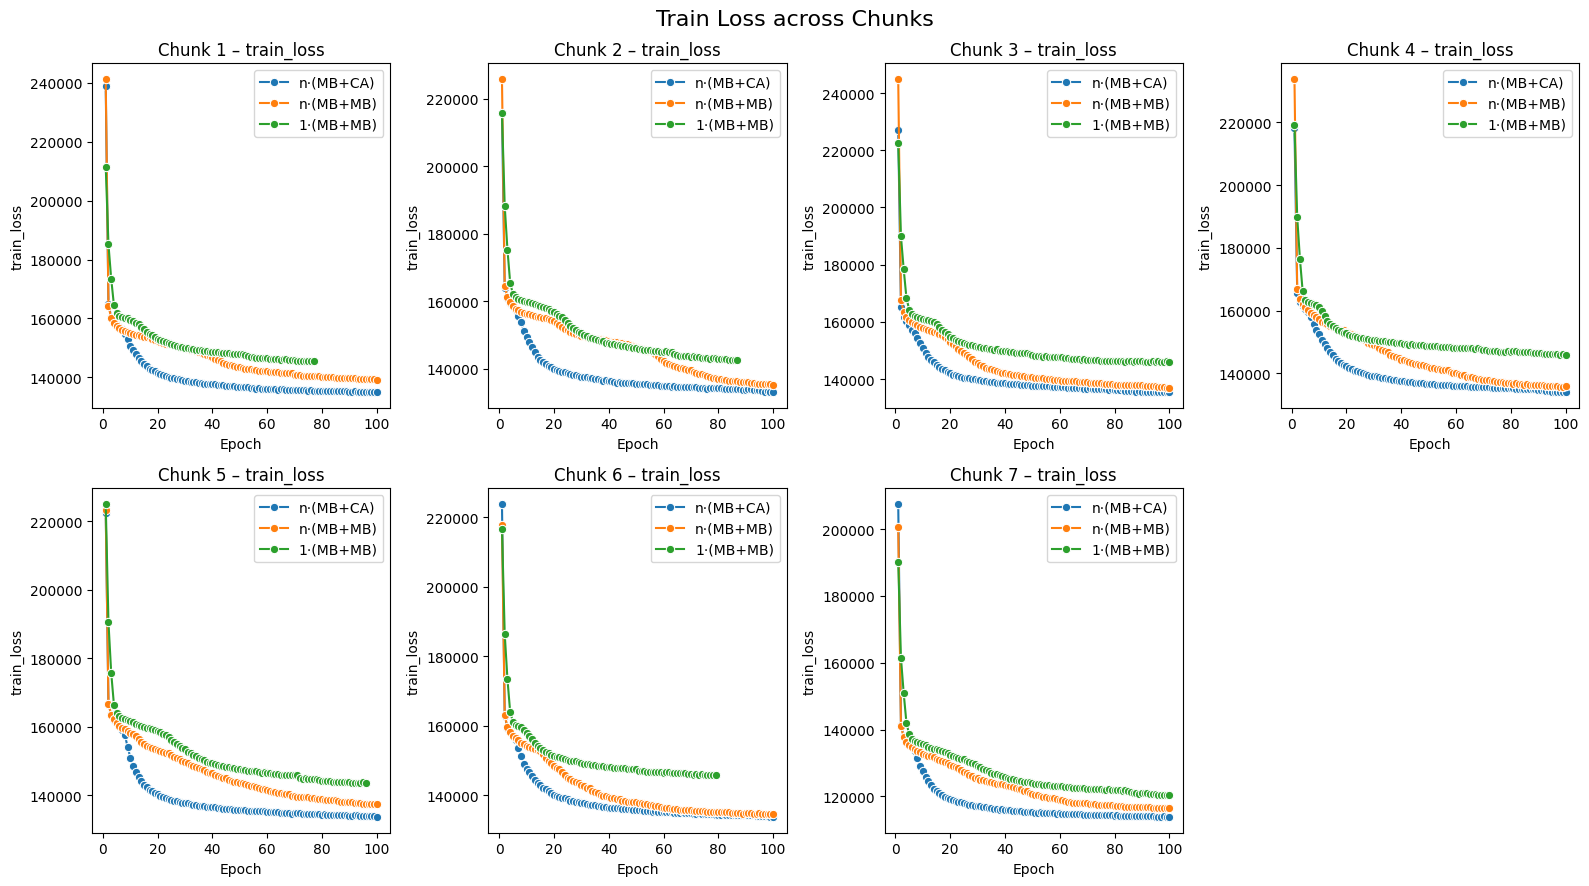

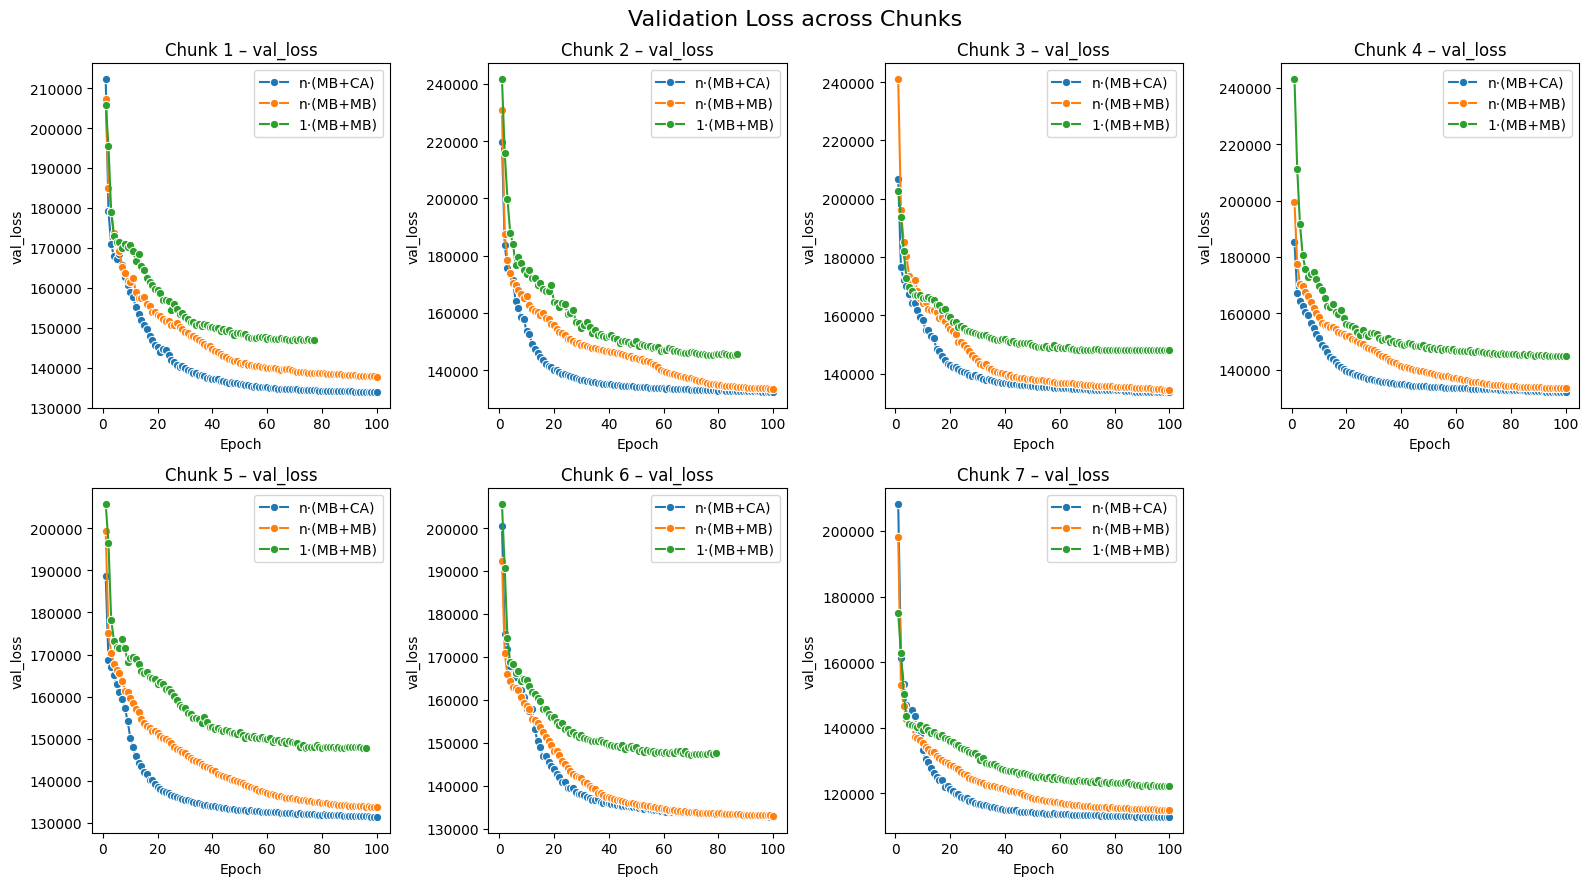

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取日志
logs_set = {
    "n·(MB+CA)": "/home/qmtang/mnt_qmtang/EvoFill/logs/251003.csv",
    "n·(MB+MB)": "/home/qmtang/mnt_qmtang/EvoFill/logs/251004.csv",
    "1·(MB+MB)": "/home/qmtang/mnt_qmtang/EvoFill/logs/251005.csv"
}

dfs = {}
for m, p in logs_set.items():
    dfs[m] = pd.read_csv(p)

# 2. 统一列名检查（可选）
# for m, df in dfs.items():
#     print(m, df.columns)

# 3. 画图：train_loss
n_chunk = 7
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
axes = axes.flatten()
for idx, chunk in enumerate(range(1, n_chunk + 1)):
    ax = axes[idx]
    for m in dfs:
        df = dfs[m]
        df_c = df[df['chunk'] == chunk]
        sns.lineplot(data=df_c, x='epoch', y='train_loss', label=m, ax=ax, marker='o')
    ax.set_title(f'Chunk {chunk} – train_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('train_loss')
    ax.legend()
# 隐藏多余子图
for j in range(n_chunk, len(axes)):
    axes[j].set_visible(False)
plt.suptitle('Train Loss across Chunks', fontsize=16)
plt.tight_layout()
plt.show()

# 4. 画图：val_loss
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
axes = axes.flatten()
for idx, chunk in enumerate(range(1, n_chunk + 1)):
    ax = axes[idx]
    for m in dfs:
        df = dfs[m]
        df_c = df[df['chunk'] == chunk]
        sns.lineplot(data=df_c, x='epoch', y='val_loss', label=m, ax=ax, marker='o')
    ax.set_title(f'Chunk {chunk} – val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('val_loss')
    ax.legend()
for j in range(n_chunk, len(axes)):
    axes[j].set_visible(False)
plt.suptitle('Validation Loss across Chunks', fontsize=16)
plt.tight_layout()
plt.show()

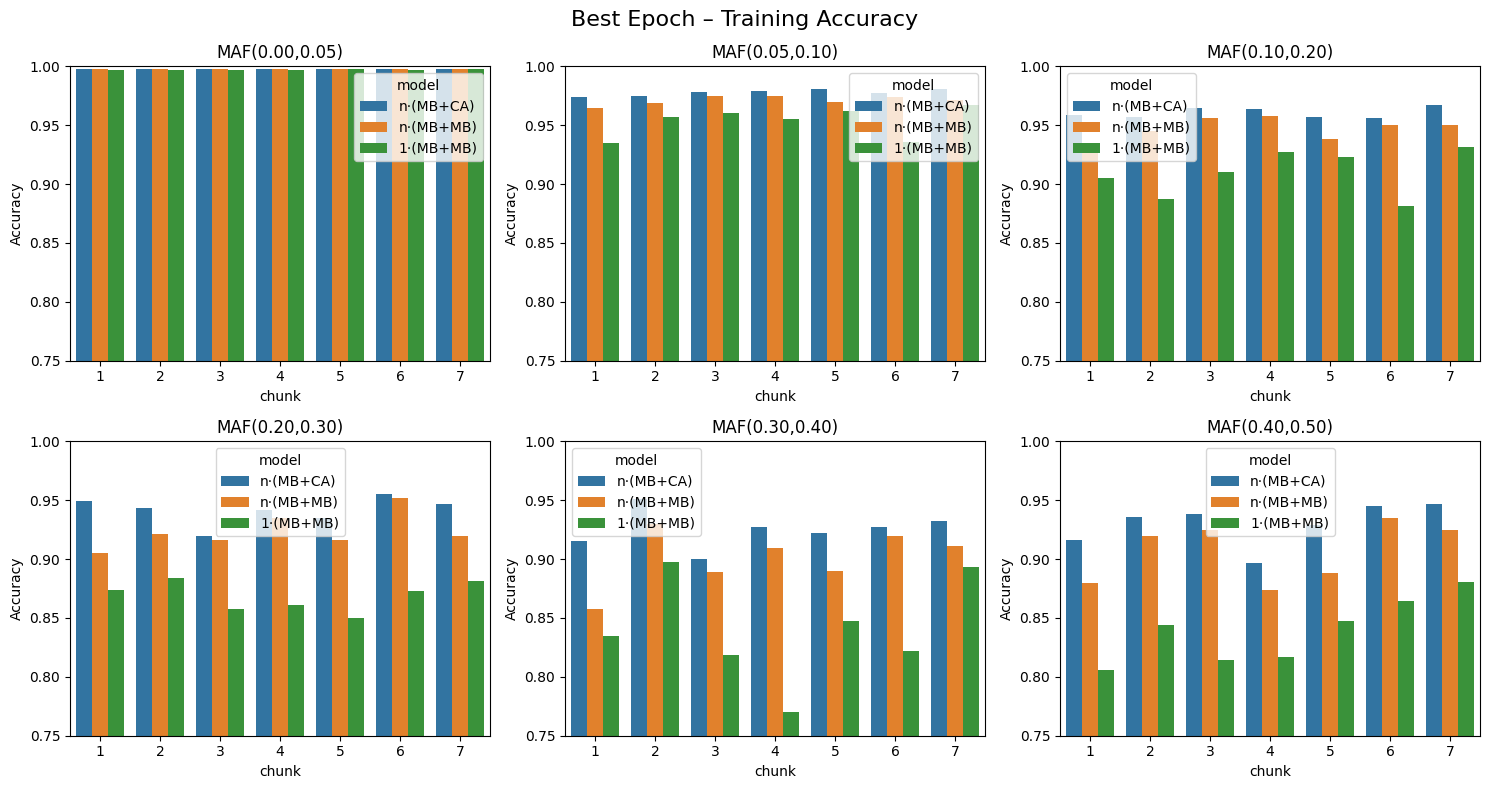

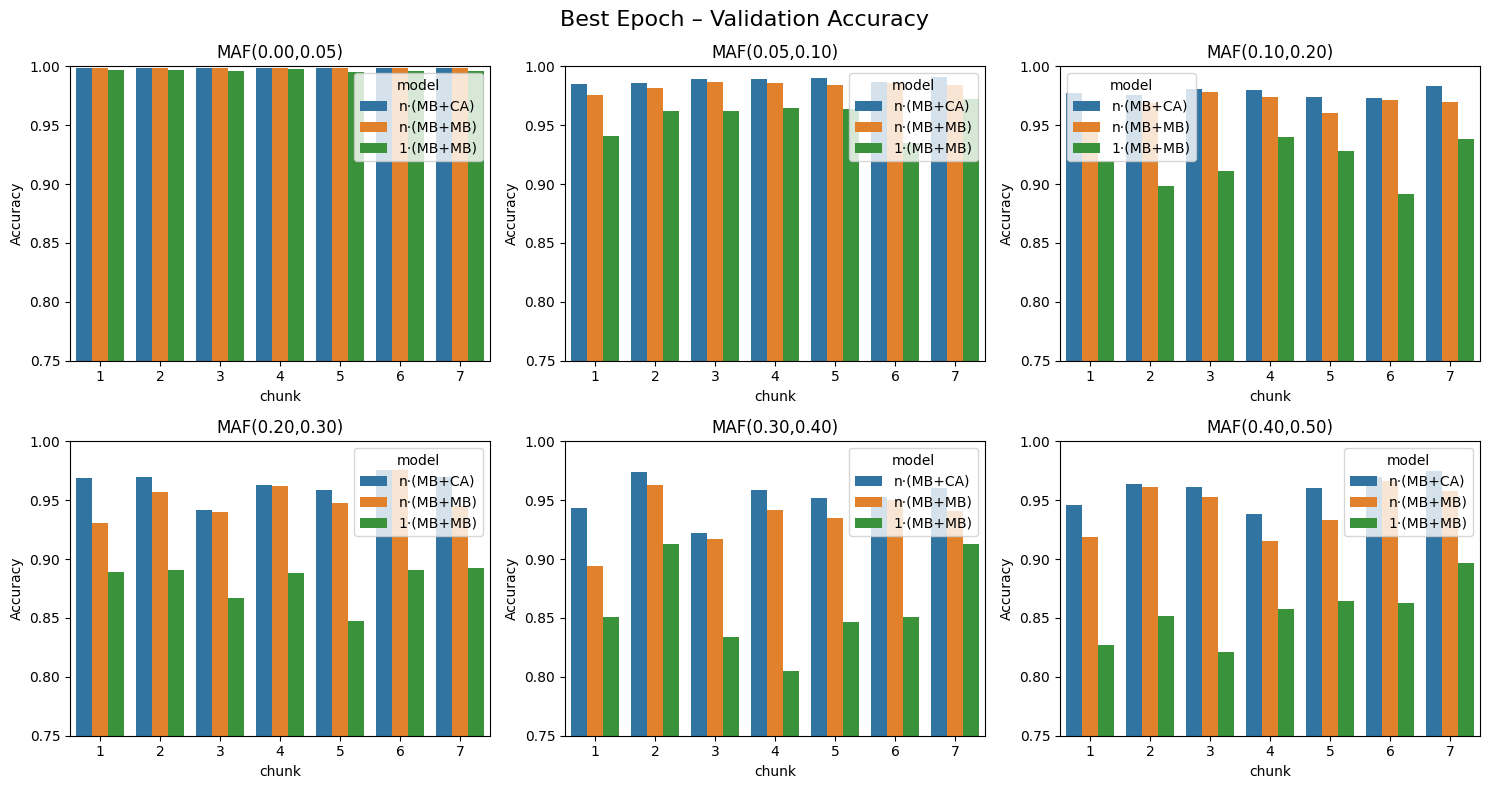

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logs_set = {
    "n·(MB+CA)": "/home/qmtang/mnt_qmtang/EvoFill/logs/251003.csv",
    "n·(MB+MB)": "/home/qmtang/mnt_qmtang/EvoFill/logs/251004.csv",
    "1·(MB+MB)": "/home/qmtang/mnt_qmtang/EvoFill/logs/251005.csv"
}

dfs = {m: pd.read_csv(p) for m, p in logs_set.items()}

# 2. 每个模型每个 chunk 取最大 epoch 的一行
best_rows = []
for m, df in dfs.items():
    best = df.loc[df.groupby('chunk')['epoch'].idxmax()].copy()
    best['model'] = m
    best_rows.append(best)
best_df = pd.concat(best_rows, ignore_index=True)

maf_cols = [f'maf_{i}_{s}' for i in range(6) for s in ['train', 'val']]
best_df.loc[best_df['model'] == "1·(MB+MB)", maf_cols] /= 100

maf_labels = [
    'MAF(0.00,0.05)',
    'MAF(0.05,0.10)',
    'MAF(0.10,0.20)',
    'MAF(0.20,0.30)',
    'MAF(0.30,0.40)',
    'MAF(0.40,0.50)'
]

# ---------- maf_0~5_train ----------
train_cols = [f'maf_{i}_train' for i in range(6)]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(train_cols):
    sns.barplot(data=best_df, x='chunk', y=col, hue='model', ax=axes[i])
    axes[i].set_ylim(0.75, 1.0)
    axes[i].set_ylabel('Accuracy')
    axes[i].set_title(maf_labels[i])
plt.suptitle('Best Epoch – Training Accuracy', fontsize=16)
plt.tight_layout()
plt.show()

# ---------- maf_0~5_val ----------
val_cols = [f'maf_{i}_val' for i in range(6)]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(val_cols):
    sns.barplot(data=best_df, x='chunk', y=col, hue='model', ax=axes[i])
    axes[i].set_ylim(0.75, 1.0)
    axes[i].set_ylabel('Accuracy')
    axes[i].set_title(maf_labels[i])
plt.suptitle('Best Epoch – Validation Accuracy', fontsize=16)
plt.tight_layout()
plt.show()